# Práctica 2: clasificación de dígitos MNIST mediante AdaBoost
---

## Introducción

En esta práctica se ha desarrollado un sistema para distinguir dígitos manuscritos del 0 al 9 en imagenes. El sistema implementado es de aprendizaje supervisado con AdaBoost. El objetivo de la práctica es entrenar al sistema, mediante un conjunto de imagenes de prueba, para clasificar imagenes en estas clases (dígitos del 0 al 9) aunque no hayan sido previamente analizadas por el sistema.

<img src="https://drive.google.com/uc?export=view&id=1CI-5CzMDSAiKRN8bE3MAniHjkVL3fDWn" width=500>

El banco de imagenes utilizado para las pruebas es la base de datos MNIST 

Lo primero será importar las librerías necesarias

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
import random, math

Desde la libería de Keras podemos descargar la base datos MNIST

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train.shape,y_train.shape

((60000, 28, 28), (60000,))

Podemos guardar la base de datos en un fichero con el siguiente comando

In [4]:
np.savez("mnist",x=x_train,y=y_train)

La cargamos para utilizarla

In [5]:
npzfile = np.load("mnist.npz")
mnist_X = npzfile['x']
mnist_Y = npzfile['y']
mnist_X.shape

(60000, 28, 28)

Veamos alguna de las imagenes del banco de datos

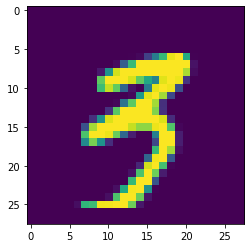

Etiqueta: 3


In [6]:
plt.figure()
plt.imshow(mnist_X[1007])
plt.show()
print("Etiqueta: " + str(mnist_Y[1007]))

### Implementación AdaBoost

Adaptación de los arrays de imágenes y etiquetas para AdaBoost en función de la clase para la que se va a entrenar

In [44]:
DIV = 10000
TEST = 20000

def adaptar_conjuntos(mnist_X, mnist_Y, clase):
    X = mnist_X[:DIV].reshape(DIV, 784)

    Y = []
    for i in range(len(mnist_Y[:DIV])):
        if mnist_Y[i] == clase:
            Y.append(1)
        else:
            Y.append(-1)
    
    return (X, Y)


def adaptar_conjuntos_test(mnist_X, mnist_Y):
    X = mnist_X.copy()
    X = np.reshape(X[DIV:TEST], (TEST - DIV, 784))

    return (X, mnist_Y)

Funciones necesarias para los clasificadores débiles

In [8]:
def generar_clasificador_debil(dimension_datos):
    return (random.randint(0, dimension_datos-1), random.randint(0, 255), random.choice((-1, 1)))

In [9]:
def aplicar_clasificador_debil(clasificador, imagen):
    v = imagen[:,clasificador[0]]
    return ((v >= clasificador[1]) * 1 + (v < clasificador[1]) * -1) * clasificador[2]

In [10]:
def obtener_error(clasificador, X, Y, D):
    return D * (aplicar_clasificador_debil(clasificador, X) != Y)

Función de entrenamiento adaboost que nos permite obtener un conjunto de clasificadores fuertes y sus respectivos valores $\alpha$.

In [27]:
def adaboost(X, Y, T, A):
    clasificadores_debiles = []
    alphas = []
    D = np.full(len(X), 1.0/len(X))

    for t in range(T):
        conjuntos = []
        for k in range(A):
            c_d = generar_clasificador_debil(28*28)                  # Obtenemos un clasificador debil
            clas = aplicar_clasificador_debil(c_d, X)         # Guardamos las clasificaciones de las imagenes
            eps = np.sum(obtener_error(c_d, X, Y, D))      # Calculamos el error 
            conjuntos.append((c_d, eps, clas))
        pri = True
        for elem in conjuntos:
            if pri:
                fc = elem
                pri = False
                continue
            if elem[1] < fc[1]:           # Guardamos el conjunto con menor error
                fc = elem  
        alph = 0.5*math.log2((1-fc[1])/fc[1])
        alphas.append(alph)
        clasificadores_debiles.append(fc[0])

        Z = np.sum(D)
        for i in range(len(D)):
            D[i] = (D[i]*(math.e**(-alph*Y[i] * fc[2][i])))/Z
        
    return (clasificadores_debiles, alphas)

Función para aplicar nuestro clasificador fuerte una vez se ha entrenado. Esta función nos permite obtener, para una imagen, el valor que tiene en una clase, según los clasificadores debiles de esta clase ponderados por su $\alpha$. 

In [13]:
def aplicar_clasificador_fuerte(clasificadores, alphas, imagen):
    clasificacion = 0
    for i in range(len(clasificadores)):
        clasificacion += alphas[i] * aplicar_clasificador_debil(clasificadores[i], np.array([imagen]))

    return clasificacion

Además se ha implementado una función que entrena el sistema para las 10 clases haciendo uso de la función adaboost

In [14]:
def entrenar_sistema(mnist_X, mnist_Y, T, A):
    clasificadores = []
    alphas = []
    for clase in range(10):
        (trainX, trainY) = adaptar_conjuntos(mnist_X, mnist_Y, clase)
        (cl, al) = adaboost(trainX, trainY, T, A)
        clasificadores.append(cl)
        alphas.append(al)
    return (clasificadores, alphas)

Se ha implementado la siguiente función que permite probar para un set de imagenes, el índice de acierto que tiene el sistema para una clase concreta.

In [31]:
def testn(X, Y, clasificadores, alphas, n):
    correct = total = 0

    for i in range(len(X)):
        if (Y[i] != n):
            continue
        total += 1
        clasif = (-1, 0)
        for j in range(10):
            punt = (aplicar_clasificador_fuerte(clasificadores[j], alphas[j], X[i]))
            if punt > clasif[1]:
                clasif = (j, punt)
        if n == clasif[0]: 
            correct += 1

    return correct/total

Veamos una prueba para la clase '6'.

In [49]:
T = 10
A = 20
print("Proceso de entrenamiento")
(clasificadores, alphas) = entrenar_sistema(mnist_X, mnist_Y, T, A)
(testX, testY) = adaptar_conjuntos_test(mnist_X, mnist_Y)
print("Proceso de pruebas")
print(f"Porcentaje de aciertos del sistema para la clase 0: {np.average(testn(testX, testY, clasificadores, alphas, 6))*100}%")

Proceso de entrenamiento
Proceso de pruebas
Porcentaje de aciertos del sistema para la clase 0: 8.875739644970414%


La función testn utilizada previamente, se puede generalizar para el conjunto de clases de la siguiente forma, de modo que permite calcular el índice de acierto que tiene el sistema en su conjunto.

In [46]:
def test(X, Y, clasificadores, alphas):
    correct = np.full(10, 0)
    total = np.full(10, 0)

    for i in range(len(X)):
        total[Y[i]] += 1
        clasif = (-1, 0)
        for j in range(10):
            punt = (aplicar_clasificador_fuerte(clasificadores[j], alphas[j], X[i]))
            if punt > clasif[1]:
                clasif = (j, punt)
        if Y[i] == clasif[0]: 
            correct[clasif[0]] += 1

    return correct/total

Vamos a realizar una prueba con valores de A y T pequeños (los definidos para el test anterior), que permita ver el funcionamiento

In [47]:
print("Proceso de entrenamiento")
(clasificadores, alphas) = entrenar_sistema(mnist_X, mnist_Y, T, A)
(testX, testY) = adaptar_conjuntos_test(mnist_X, mnist_Y)
print("Proceso de pruebas")
print(f"Porcentaje de aciertos del sistema: {np.average(test(testX, testY, clasificadores, alphas))*100}%")

Proceso de entrenamiento
Proceso de pruebas
Porcentaje de aciertos del sistema: 6.7731031763100304%


Para realizar un análisis que ayude a determinar los valores adecuados para T y A se ha utilizado la siguiente función

In [42]:
def valorarAT(X, Y, A, T, At, Ta):
    resultsA = []
    for i in At:
        (clasificadores, alphas) = entrenar_sistema(X, Y, T, i)
        (testX, testY) = adaptar_conjuntos_test(X, Y)
        resultsA.append(test(testX, testY, clasificadores, alphas))    

    resultsT = []
    for i in Ta:
        (clasificadores, alphas) = entrenar_sistema(X, Y, i, A)
        (testX, testY) = adaptar_conjuntos_test(X, Y)
        resultsT.append(test(testX, testY, clasificadores, alphas))
    return (resultsA, resultsT) 

En esta función se entrena el sistema en función de los valores de `At` con T constante, y se obtienen los resultados para cada uno de estos entrenamientos. Despues s ehace lo propio pero para cada valor de `Ta` con A constante.

# Cuestiones sobre la práctica

## Explica brevemente cómo has adaptado la base datos MNIST al algoritmo AdaBoost

Para adaptar los elementos de la base de datos de MNIST al algoritmo de entrenamiento, se ha utilizado la función `adaptar_conjuntos` formulada previamente. Esta función consiste en darle una nueva forma a cada imagen. Por defecto las imágenes de MNIST son de 28x28 píxeles, pero en esta función se estreuctura de forma que sean un único vector con los 784 píxeles seguidos, de forma que sea más sencillo de acceder a cada píxel individual. También se han editado las etiquetas, poniendo los valores 1, si es la clase a entrenar, y -1 en caso contrario. Por este motivo, para cada clase a entrenar, se debe adaptar de nuevo los datos. Además, del conjunto total de imagenes se han seleccionado para entrenar, las primeras 20000.

Por otro lado, se han tenido que adaptar también estos datos al algoritmo de prueba, con la función `adaptar_conjuntos_test`. En este caso, para adaptar las imagenes, se hace del mismo modo. La diferencia recae en las etiquetas, las cuales se quedan tal cual está en la base de datos. Para el conjunto de datos de testeo se han utilizado las siguientes 10000 imagenes, esto es, de la 20001 a la 30000.

## Comenta detalladamente el funcionamiento de AdaBoost teniendo en cuenta que tasa media de fallos obtienes para aprendizaje y test. Correlaciona los porcentajes de acierto y de fallo con los valores de A y de T.

AdaBoost es un algoritmo mediante el cual obtener clasificadores fuertes a través de un entrenamiento. Cuenta con dos parámetros importantes, A y T. A define el número de clasificadores aleatorios que vamos a obtener para probar y obtener un clasificador débil. El parámetro T por otro lado, indica el número de clasificadores débiles que compondrán nuestro clasificador fuerte.

Con la función `valorarAT` definida previamente, se tratará de ver que papel cumplen A y T en la precisión del sistema. Para ello lanzaremos la siguiente prueba:

In [ ]:
T = 10
A = 300
At = range(100, 1301, 80)
Ta = range(40, 321, 40)

(rA, rT) = valorarAT(mnist_X, mnist_Y, A, T, At, Ta)
rAcorr = [np.average(i) for i in rA]
rTcorr = [np.average(i) for i in rT]

plt.figure()
plt.plot(At, rAcorr, 'r-o')
plt.title(f"Precisión del sistema en función de A con T = {T}")
plt.savefig("valoA.pdf", format="pdf")
plt.show()
plt.figure()
plt.plot(Ta, rTcorr, 'b-o')
plt.title(f"Precisión del sistema en función de T con A = {A}")
plt.savefig("valoT.pdf", format="pdf")
plt.show()

Estas gráficas muestran detalles importantes de Adaboost. 

El primero de ellos es que existe una relación lineal entre el valor de A y T con la precisión del sistema, esto es, aumentar el valor de A o de T, aumentará el índice de aciertos del sistema. Aún así, vemos que esta relación no es estricta, es decir, vemos que en algunas pruebas con valores de A mayores, obtenemos un acierto menor. Esto se debe a que el modo de obtener clasificadores es aleatorio, y aún siendo cierto que a mayor número de clasificadores probados, aumentará la fiabilidad, no es seguro que el clasificador final sea mejor que uno obtenido con menor valor de A. Respecto a T vemos que la precisión parece estancarse en cierto punto.

El segundo detalle es la influencia de A y T en la gráfica de precisión. El valor de A es el que da estabilidad a la gráfica para diferentes valores de T, pues al aumentar A se reduce la aleatoriedad del clasificador y viceversa. Por otro lado, el valor de T desplaza la curva para diferentes valores de A verticalmente, esto es, a mayor valor de T, veríamos unos mayores porcentajes de acierto y a la inversa.

## ¿Cómo afecta el número de clasificadores generados al tiempo empleado para el proceso de aprendizaje? ¿Qué importancia le darías? Justifica tu respuesta. 

El tiempo de aprendizaje del algoritmo depende linealmente de básicamente tres variables, que son, el número de clasificadores débiles a obtener (T), los clasificadores débiles aleatorios por cada iteración (A) y la cántidad de imagenes utilizadas (X). No modificando A ni X, el tiempo de aprendizaje dependerá linealmente de T, esto es, aumentar el valor de T en una proporción hará aumentar el tiempo destinado al aprendizaje en esta misma proporción. 

A mayor número de clasificadores débiles entrenemos en nuestro algoritmo, obtendremos unos resultados mejores, esto es un porcentaje de acierto mayor. A pesar de ser cierto esto, el incremento de precisión del sistema no es lineal con el incremento de T, sino que más bien describe una función $log(T)$. Es por esto que no se puede escoger un número muy elevado para T, pues mientras el tiempo de entrenamiento crece linealmente con T, la precisión acaba estancandose.

Resumiendo, debe escogerse un número de T apropiado al problema y a la precisión necesaria en este caso, teniendo en cuenta el tiempo disponible para el entrenamiento, y para obtener este valor de T, lo apropiado es realizar numerosas pruebas en las que se prueben diversos valores para escoger de entre estos el que consideremos óptimo.

## ¿Cómo has dividido los datos en conjunto de entrenamiento y test? ¿Para qué es útil hacer esta división? 

Los diferentes conjuntos se han dividido a través de las dos funciones diferentes de adaptar conjuntos. En estas funciones se han definido unos valores `DIV` y `TEST` que permiten dividirlos. Para el conjunto de entrenamiento se han utilizado las primerass `DIV` imagenes de mnist, y para el test se han utilizado desde la imagen `DIV` hasta la imagen `TEST`.

No solo es útil hacer esta división, es necesario para hacer un test riguroso del sistema. Si utilizaramos las imagenes de entrenamiento en el test, obtendriamos resultados muy elevados de precisión, pues es con estas mismas imágenes con las que el sistema ha aprendido a diferenciar. Al utilizar otras imagenes, la fialidad del sistema bajará mucho, y es por esto que en ese se deberá utilizar mayores valores de A y T.

## ¿Has observado si se produce sobre entrenamiento? Justifica tu respuesta con una gráfica en la que se compare el error de entrenamiento y el de test a lo largo de las ejecuciones. 

## ¿Cómo has conseguido que Adaboost clasifique entre los 10 dígitos cuando solo tiene una salida binaria?

Al utilizar adaboost se obtiene un conjunto de clasificadores débiles para una clase con salida binaria. Estos clasificadores débiles componen un clasificador fuerte, que nos permite obtener un valor al ponderar cada uno de estos clasificadores débiles con su valor $\alpha$.

A partir de esta idea, si se lanza el algoritmo Adaboost para cada una de las clases, obtendremos un clasificador fuerte para cada clase. A partir de este 'sistema' de clasificadores, es posible, para una imagen, al aplicar cada uno de estos clasificadores fuertes, que devolverán valores numéricos, determinar a qué clase pertenece la imagen con el valor del clasifiador más alto. Por ejemplo, si para una imagen cualquiera se aplican los clasificadores del sistema, y obtenemos los valores para la clase 0 = 2.45 y para la clase 7 = 3.12, el sistema dirá que esta imagen contiene un 7.

# Ampliación Julio

## ¿Varía T y A entre ambos clasificadores débiles al usarlos en Adaboost? ¿Cuál requiere un T más elevado? ¿Porqué?

## ¿Qué clasificador débil crees que funciona mejor para clasificar un dígito? ¿Y el problema completo con 10 dígitos?